## Experiment on Subject dependent Stratagies for EEG based emotion classification

> Referenced Paper : https://www.researchgate.net/publication/341129348_A_Comparative_Study_of_Subject-Dependent_and_Subject-Independent_Strategies_for_EEG-Based_Emotion_Recognition_using_LSTM_Network

#### Summary:
> This paper explores both subject independent and subject dependent strategies
> Tested models : KNN, SVM, DecisionTree, RandomForest, LSTM 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import mne
from mne.time_frequency import stft

In [2]:
#Path to the dataset 
FOLDER_PATH = 'data/'
#get all files within the path
files_list = sorted(glob(FOLDER_PATH + '*'))   
print(files_list)

['data\\s01.dat', 'data\\s02.dat', 'data\\s03.dat', 'data\\s04.dat', 'data\\s05.dat', 'data\\s06.dat', 'data\\s07.dat', 'data\\s08.dat', 'data\\s09.dat', 'data\\s10.dat', 'data\\s11.dat', 'data\\s12.dat', 'data\\s13.dat', 'data\\s14.dat', 'data\\s15.dat', 'data\\s16.dat', 'data\\s17.dat', 'data\\s18.dat', 'data\\s19.dat', 'data\\s20.dat', 'data\\s21.dat', 'data\\s22.dat', 'data\\s23.dat', 'data\\s24.dat', 'data\\s25.dat', 'data\\s26.dat', 'data\\s27.dat', 'data\\s28.dat', 'data\\s29.dat', 'data\\s30.dat', 'data\\s31.dat', 'data\\s32.dat']


In [3]:
import pickle
#Original shape of DEAP dataset 32 = participants, 40 = clips / person, 40 = channels, 8064 = signals each 
#total samples of 8064 * 1280 = 10,321,920
org_data = np.zeros((32,40,40,8064))

#Original shape of the labels 32 = participants, 40 = clips, 4 = targets = Valence, Arousal, Dominance, Likeness
org_labels = np.zeros((32,40,4))

for i, f in (enumerate(tqdm(files_list))):
      with open(f, 'rb') as f: 
        content = pickle.load(f, encoding='iso-8859-1')
        data = content['data']
        labels = content['labels'] 
        org_data[i] = data
        org_labels[i] = labels
        

100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


In [4]:
print(f"Original Shape of the data: {org_data.shape}")
print(f"Original Shape of the labels:{org_labels.shape}")

Original Shape of the data: (32, 40, 40, 8064)
Original Shape of the labels:(32, 40, 4)


In [5]:
signals = ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2', 'hEOG (horizontal EOG, hEOG1 - hEOG2)', 'vEOG (vertical EOG, vEOG1 - vEOG2)', 'zEMG (Zygomaticus Major EMG, zEMG1 - zEMG2)', 'tEMG (Trapezius EMG, tEMG1 - tEMG2)', 'GSR (values from Twente converted to Geneva format (Ohm))', 'Respiration belt', 'Plethysmograph', 'Temperature']
eeg_signals = signals[:32]
phy_signals = signals[32:]
labels = ['valence', 'arousal', 'dominance', 'liking']

print(f"EEG signals: {eeg_signals}")
print(f"Physiological signals : {phy_signals}")

EEG signals: ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2']
Physiological signals : ['hEOG (horizontal EOG, hEOG1 - hEOG2)', 'vEOG (vertical EOG, vEOG1 - vEOG2)', 'zEMG (Zygomaticus Major EMG, zEMG1 - zEMG2)', 'tEMG (Trapezius EMG, tEMG1 - tEMG2)', 'GSR (values from Twente converted to Geneva format (Ohm))', 'Respiration belt', 'Plethysmograph', 'Temperature']


In [6]:
#Combining clips / person we get 32 * 40 = 1280 
eeg_data = org_data.reshape(-1, 40, 8064)
#Also taking only 32 channels as 32 are EEG signals and 8 are physiological signals
eeg_data = eeg_data[:,:32,:]

print(f"Proper EEG data shape: {eeg_data.shape}")

Proper EEG data shape: (1280, 32, 8064)


In [7]:
#Reshaping the labels data to 1280, 4
eeg_labels = org_labels.reshape(-1, 4)
print("EEG Labels shape: " , eeg_labels.shape)

EEG Labels shape:  (1280, 4)


In [8]:
# The DEAP dataset contains frequency power of trails and baselines btween 3 and 47 Hz, So we can use only 4 frequncy bands Theta, Alpha, Beta, Gamma
theta_band = [3, 7]
alpha_band = [8, 13]
beta_band = [14, 29]
gamma_band = [30, 47]

print(f"Theta Band: high : {theta_band[1]}, low: {theta_band[0]}")
print(f"Alpha Band: high : {alpha_band[1]}, low: {alpha_band[0]}")
print(f"Beta Band: high : {beta_band[1]}, low: {beta_band[0]}")
print(f"Gamma Band: high : {gamma_band[1]}, low: {gamma_band[0]}")

Theta Band: high : 7, low: 3
Alpha Band: high : 13, low: 8
Beta Band: high : 29, low: 14
Gamma Band: high : 47, low: 30


In [9]:
# Binarizing the eeg_labels
eeg_data_binary = np.where(eeg_labels > 5, 1, 0)

In [10]:
# Extracting the valence and arousal labels seperately from eeg_labels which contains(valence, arousal, dominance, likeness)
valence_data = eeg_data_binary[:, 0] 
arousal_data = eeg_data_binary[:, 1]

print(f"Valence data shape: {valence_data.shape}")
print(f"Arousal data shape: {arousal_data.shape}")

Valence data shape: (1280,)
Arousal data shape: (1280,)


In [11]:
import seaborn as sns

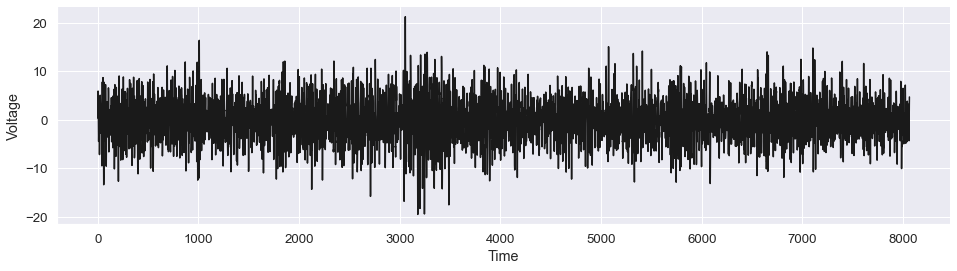

In [12]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
# time = np.arange(X_train.size) / sf
# Plot the signal of first trial, last channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(eeg_data[0,31], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

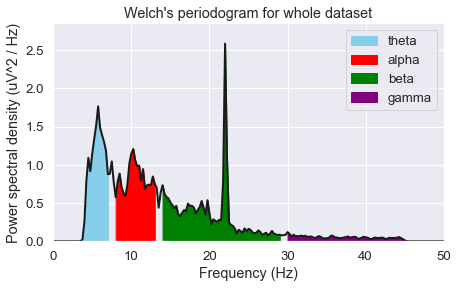

In [13]:
from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway
sf = 128.
win = 4 * sf
freqs, psd = signal.welch(eeg_data[0][0], sf, nperseg=win) 

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= theta_band[0], freqs <= theta_band[1])
idx_alpha= np.logical_and(freqs >= alpha_band[0], freqs <= alpha_band[1])
idx_beta = np.logical_and(freqs >= beta_band[0], freqs <= beta_band[1])
idx_gamma = np.logical_and(freqs >=  gamma_band[0], freqs <= gamma_band[1])

# Plot the power spectral density and fill the theta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_theta, color='skyblue', label = 'theta')
plt.fill_between(freqs, psd, where=idx_alpha, color='red', label = 'alpha')
plt.fill_between(freqs, psd, where=idx_beta, color='green', label = 'beta')
plt.fill_between(freqs, psd, where=idx_gamma, color='purple', label = 'gamma')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram for whole dataset")
plt.legend()
sns.despine()

In [14]:
def bandpower(data, sf, band, window_sec=None, relative=False): #Relative is set to False 
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

def frequency_bands(data, band): 
 
  if (band == "theta"): # drownsiness, emotional connection, intuition, creativity
    bd = theta_band
  elif (band == "alpha"): # reflection, relaxation
    bd = alpha_band
  elif (band == "beta"): # concentration, problem solving, memory
    bd = beta_band
  elif (band == "gamma"): # cognition, perception, learning, multi-tasking
    bd = gamma_band
  return bandpower(data,128, bd)

In [15]:
def get_band_powers(data):
    power = np.zeros([4])
    bands = ["theta", "alpha", "beta", "gamma"]
    for idx, band in enumerate(bands):
        power[idx] = frequency_bands(data, band)
    return power

In [16]:
get_band_powers(eeg_data[0][0])

array([2.24965576, 3.36279149, 5.35815862, 0.        ])

In [17]:
n_samples = eeg_data.shape[0]
n_channels = 32
n_band = 4
psd = np.zeros((n_samples, n_channels, n_band))

for i in tqdm(range(n_samples)):
    for j in range(n_channels):
        psd[i,j] = get_band_powers(eeg_data[i][j])

print(psd.shape)

100%|██████████| 1280/1280 [01:51<00:00, 11.43it/s]

(1280, 32, 4)


## Seperating individuals

In [18]:
indi_data = {}
indi_valence = {}
indi_arousal = {}
num_subjects = org_data.shape[0]

In [19]:
#seperating individual participants 
for i in tqdm(range(num_subjects)):
    subject_lbl = "subject_" + str(i+1)
    indi_data[subject_lbl] = org_data[i, :, :32, :]

print("Done!")
assert(len(indi_data) == 32)

100%|██████████| 32/32 [00:00<?, ?it/s]

Done!


In [20]:
print(org_data.shape)

(32, 40, 40, 8064)


In [21]:
indi_data["subject_1"].shape

(40, 32, 8064)

In [22]:
 for i in tqdm(range(num_subjects)):
    subject_lbl = "subject_" + str(i+1)
    current_lbl = org_labels[i, :]
    lbl_bin = np.where(current_lbl > 5, 1, 0)
    indi_valence[subject_lbl] = lbl_bin[:, 0]
    indi_arousal[subject_lbl] = lbl_bin[:, 1]

print("Done!")
assert(indi_valence["subject_1"].shape[0] == 40)
assert(indi_arousal["subject_1"].shape[0] == 40)

100%|██████████| 32/32 [00:00<00:00, 31979.44it/s]

Done!


### Testing on Participant 1 with 40 clips

In [23]:
sub_1 = indi_data["subject_1"]

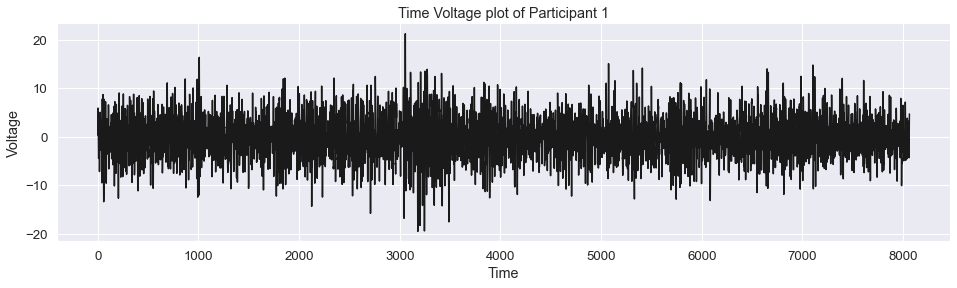

In [24]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
# time = np.arange(X_train.size) / sf
# Plot the signal of first trial, last channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(sub_1[0 ,31], lw=1.5, color='k') 
plt.title("Time Voltage plot of Participant 1")
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

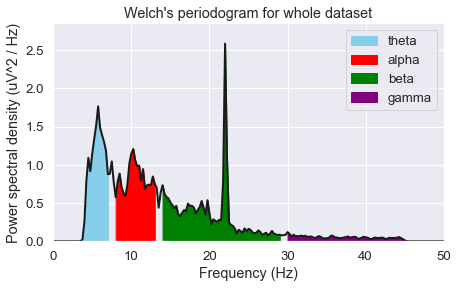

In [25]:
from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway
sf = 128.
win = 4 * sf
freqs, psd = signal.welch(sub_1[0][0], sf, nperseg=win) 

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= theta_band[0], freqs <= theta_band[1])
idx_alpha= np.logical_and(freqs >= alpha_band[0], freqs <= alpha_band[1])
idx_beta = np.logical_and(freqs >= beta_band[0], freqs <= beta_band[1])
idx_gamma = np.logical_and(freqs >=  gamma_band[0], freqs <= gamma_band[1])

# Plot the power spectral density and fill the theta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_theta, color='skyblue', label = 'theta')
plt.fill_between(freqs, psd, where=idx_alpha, color='red', label = 'alpha')
plt.fill_between(freqs, psd, where=idx_beta, color='green', label = 'beta')
plt.fill_between(freqs, psd, where=idx_gamma, color='purple', label = 'gamma')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram for whole dataset")
plt.legend()
sns.despine()

In [26]:
n_samples = sub_1.shape[0]
n_channels = 32
n_band = 4
psd = np.zeros((n_samples, n_channels, n_band))

for i in tqdm(range(n_samples)):
    for j in range(n_channels):
        psd[i,j] = get_band_powers(eeg_data[i][j])

print(psd.shape)

100%|██████████| 40/40 [00:05<00:00,  7.79it/s]

(40, 32, 4)


In [27]:
valence_1 = indi_valence["subject_1"]
arousal_1 = indi_arousal["subject_1"]

In [28]:
X_train_1 = psd[:20, :].reshape(-1, 32*4)
X_test_1 =  psd[20:, :].reshape(-1, 32*4)

val_train_1 = valence_1[:20].reshape(-1, 1)
val_test_1 = valence_1[20:].reshape(-1, 1)

X_train_1.shape

(20, 128)

In [29]:
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.metrics import average_precision_score, classification_report 
from sklearn.metrics import accuracy_score
model = SVC(kernel = 'rbf')
model.fit(X_train_1,np.ravel(val_train_1))  
yhat = model.predict(X_test_1) 
print(yhat)
print("========= Valence Average precision score=======")
print(average_precision_score(val_test_1, yhat))
print("========= Valence Accuracy score=======")
print(accuracy_score(val_test_1, yhat))
print("=========Valence Classification report=======")
print("Report: ", classification_report(val_test_1, yhat)) 

[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1]
========= Valence Average precision score=======
0.4444444444444444
========= Valence Accuracy score=======
0.5
=========Valence Classification report=======
Report:                precision    recall  f1-score   support

           0       1.00      0.17      0.29        12
           1       0.44      1.00      0.62         8

    accuracy                           0.50        20
   macro avg       0.72      0.58      0.45        20
weighted avg       0.78      0.50      0.42        20



In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV

model = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(2, 10)}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
grid.fit(X_train_1, np.ravel(val_train_1))

print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

model = grid.best_estimator_

model.fit(X_train_1,  np.ravel(val_train_1))
yhat = model.predict(X_test_1)



print("Accuracy: ", np.sum(yhat == val_test_1)/len(val_test_1))

The best parameters are {'n_neighbors': 3} witha score of 0.65
Accuracy:  9.2


In [31]:
indi_psd = {}

for  sub in tqdm(range(32)):
    subject_lbl = "subject_" + str(sub+1)
    psd = np.zeros((n_samples, n_channels, n_band))
    for i in range(n_samples):
        for j in range(n_channels):
            psd[i,j] = get_band_powers(org_data[sub, i, j])
    indi_psd[subject_lbl] = psd.reshape(-1, 32*4)
     

100%|██████████| 32/32 [02:11<00:00,  4.12s/it]


In [32]:
indi_acc= {}
indi_acc_ar= {}
indi_models = {}
def SVM(X_train, y_train, X_test, y_test, subject, valence = True ): 
    model = SVC(kernel = 'rbf') 
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)   
    acc = accuracy_score(y_test, yhat)  
    indi_models[subject] = model
    if valence == False:
        indi_acc_ar[subject] = acc
    else:
        indi_acc[subject] = acc

In [33]:
tts_distribution = 30

In [34]:

for sub in tqdm(indi_psd):
    X_train = indi_psd[sub][:tts_distribution, :]
    X_test = indi_psd[sub][tts_distribution:,:]
    val_y_train = indi_valence[sub][:tts_distribution]
    val_y_test = indi_valence[sub][tts_distribution:]
    SVM(X_train, val_y_train, X_test, val_y_test, sub)


100%|██████████| 32/32 [00:00<00:00, 1144.43it/s]


In [35]:

for sub in tqdm(indi_psd):
    X_train = indi_psd[sub][:tts_distribution, :]
    X_test = indi_psd[sub][tts_distribution:,:]
    y_train = indi_arousal[sub][:tts_distribution]
    y_test = indi_arousal[sub][tts_distribution:]
    SVM(X_train, y_train, X_test, y_test, sub, valence=False)


100%|██████████| 32/32 [00:00<00:00, 1104.92it/s]


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]


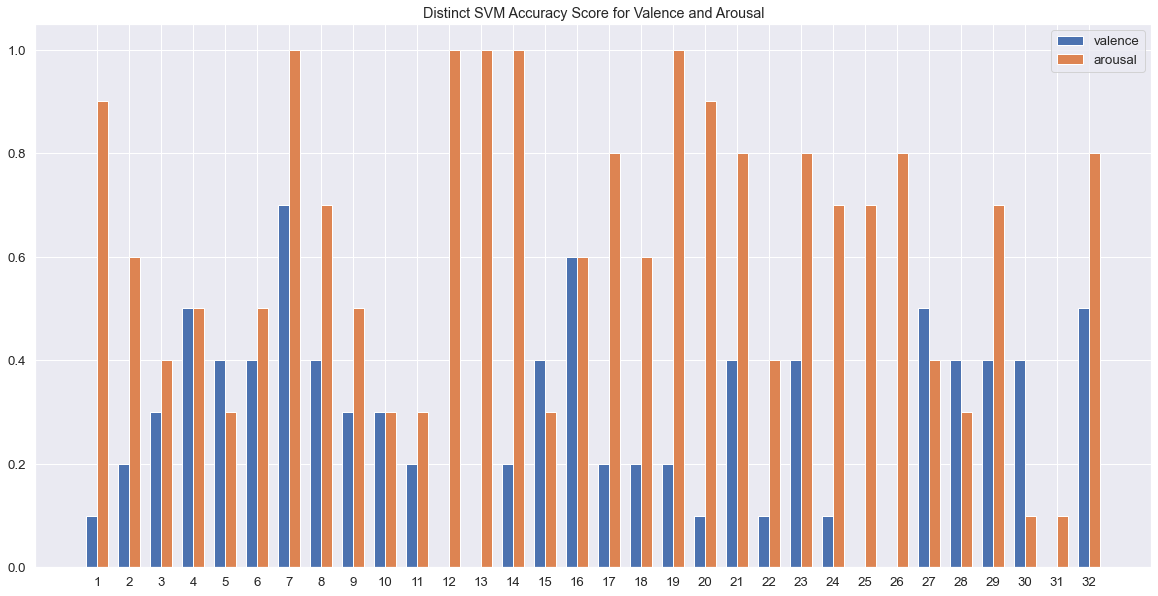

In [36]:
fig, ax = plt.subplots(figsize=(20,10))
index = np.arange(1, len(indi_acc)+1)
print(index)
indi_arr = np.array([indi_acc[_] for _ in indi_acc ])
indi_arr_ar = np.array([indi_acc_ar[_] for _ in indi_acc_ar ])
ax.bar(index - 0.35/2 , indi_arr, 0.35, label = "valence")
ax.bar(index + 0.35/2, indi_arr_ar,0.35, label = "arousal")
ax.set_xticks(index);
ax.set_title("Distinct SVM Accuracy Score for Valence and Arousal")
ax.legend()

In [37]:
valence_svm_mean_acc = np.mean(indi_arr)
arousal_svm_mean_acc = np.mean(indi_arr_ar)

In [38]:
print(f"Mean Valence Accuracy on SVM: {np.round(valence_svm_mean_acc * 100.)}%")
print(f"Mean Arousal Accuracy on SVM: {np.round(arousal_svm_mean_acc * 100.)}%")

Mean Valence Accuracy on SVM: 28.0%
Mean Arousal Accuracy on SVM: 62.0%


In [39]:
def test_dependent():
    X = indi_psd["subject_31"]
    y = indi_arousal["subject_31"]
    model = SVC(kernel = 'rbf') 
    model.fit(X, y) 
    X_test = indi_psd["subject_12"] 
    y_test = indi_arousal["subject_12"]
    yhat = model.predict(X_test) 
    acc = accuracy_score(y_test, yhat ) 
    print(yhat)
    return acc

In [40]:
test_dependent()

[1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1
 1 1 1]


0.625

In [41]:
indi_valence_acc= {}
indi_arousal_acc= {}
indi_svm_models = {}

def SVM(X_train, y_train, X_test, y_test, subject, valence = True ): 
   
    model = SVC(kernel = 'rbf') 
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)  
    
    acc = accuracy_score(y_test, yhat)  
    indi_svm_models[subject] = model 
    if valence == False:
        
        indi_arousal_acc[subject] = acc
    else: 
        indi_valence_acc[subject] = acc

In [42]:
for idx, sub in tqdm(enumerate(indi_psd)):
    current_sub = idx+1
    if(current_sub == 1):
        prior_sub = 32
    else:
        prior_sub = current_sub - 1
        
    train_subject_label = "subject_" + str(prior_sub)
    test_subject_label = "subject_" + str(current_sub)
    X_train = indi_psd[train_subject_label]
    X_test = indi_psd[test_subject_label]
    
    val_y_train = indi_valence[train_subject_label]
    val_y_test = indi_valence[test_subject_label]
    
    SVM(X_train, val_y_train, X_test, val_y_test, sub)


32it [00:00, 890.16it/s]


In [43]:
for idx, sub in tqdm(enumerate(indi_psd)):
    current_sub = idx+1 
    if(current_sub == 1):
        prior_sub = 32 
    else:
        prior_sub = current_sub - 1
        
    train_subject_label = "subject_" + str(prior_sub)
    test_subject_label = "subject_" + str(current_sub)
    X_train = indi_psd[train_subject_label]
    X_test = indi_psd[test_subject_label]
    
    arr_y_train = indi_arousal[train_subject_label]
    arr_y_test = indi_arousal[test_subject_label]
    
    SVM(X_train, arr_y_train, X_test, arr_y_test, sub, valence = False)


32it [00:00, 916.77it/s]


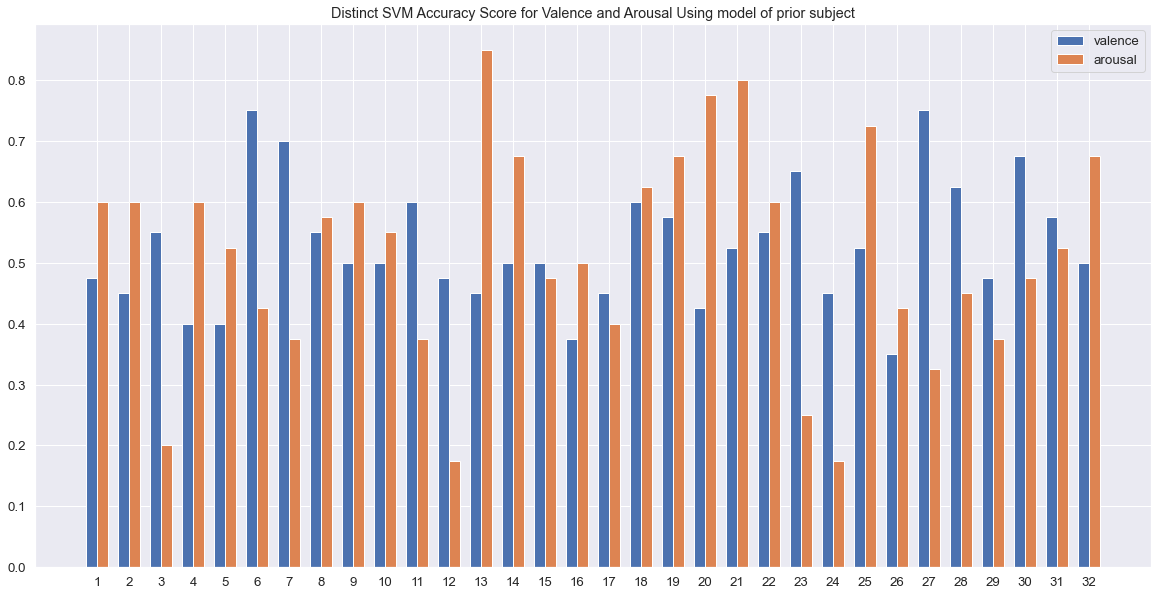

In [44]:
fig, ax = plt.subplots(figsize=(20,10))
index = np.arange(1, len(indi_valence_acc)+1) 

indi_arr = np.array([indi_valence_acc[_] for _ in indi_valence_acc ])
indi_arr_ar = np.array([indi_arousal_acc[_] for _ in indi_arousal_acc ])
ax.bar(index - 0.35/2 , indi_arr, 0.35, label = "valence")
ax.bar(index + 0.35/2, indi_arr_ar,0.35, label = "arousal")
ax.set_xticks(index);
ax.set_title("Distinct SVM Accuracy Score for Valence and Arousal Using model of prior subject")
ax.legend()

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV

indi_val_knn = {}
indi_aro_knn = {}
indi_knn_models = {} 

def KNN(X_train, X_test, y_train, y_test, sub, valence = True):   
    model = KNeighborsClassifier()
    param_grid = {"n_neighbors": np.arange(2, 10)}

    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
    grid.fit(X_train, np.ravel(y_train))

#     print(f"The best parameters are {grid.best_params_} with" +
#               f"a score of {grid.best_score_:.2f}")

    model = grid.best_estimator_

    model.fit(X_train,  np.ravel(y_train))
    yhat = model.predict(X_test) 
    acc = np.sum(yhat == y_test)/len(y_train)
    
    if(valence == True):
        indi_val_knn[sub] = acc
    else:
        indi_aro_knn[sub] = acc
        
    indi_knn_models[sub] = model

    

In [49]:

for sub in tqdm(indi_psd):
    X_train = indi_psd[sub][:tts_distribution, :]
    X_test = indi_psd[sub][tts_distribution:,:]
    val_y_train = indi_valence[sub][:tts_distribution]
    val_y_test = indi_valence[sub][tts_distribution:]
    KNN(X_train, X_test, val_y_train, val_y_test, sub, valence=True)


100%|██████████| 32/32 [00:02<00:00, 13.84it/s]


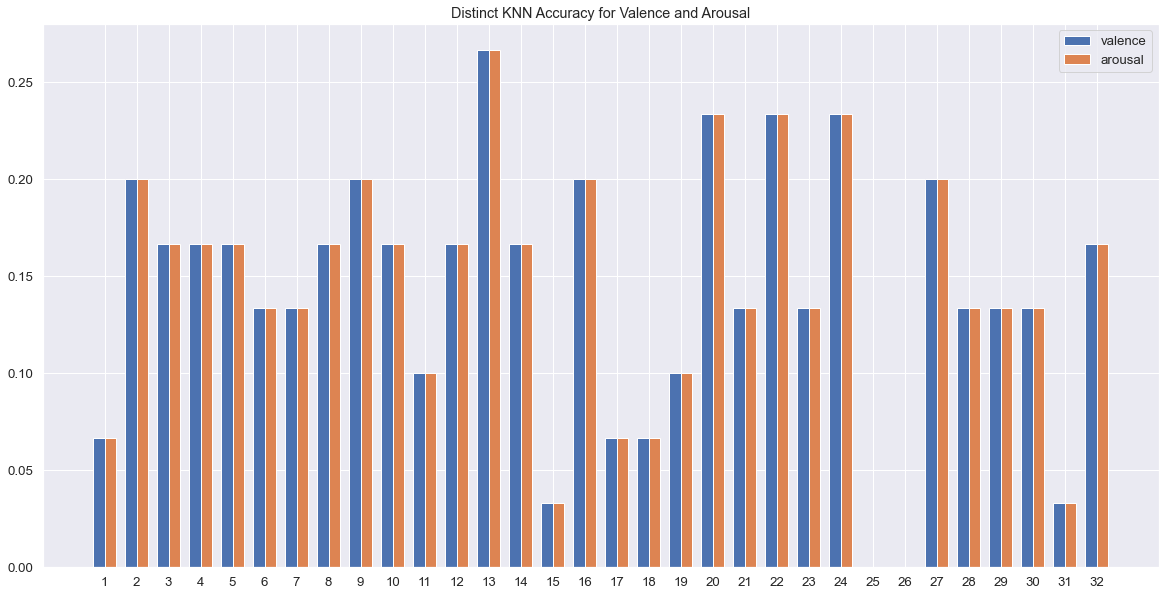

In [50]:
fig, ax = plt.subplots(figsize=(20,10))
index = np.arange(1, len(indi_val_knn)+1) 

indi_arr_knn = np.array([indi_val_knn[_] for _ in indi_val_knn ])
indi_arr_ar_knn = np.array([indi_aro_knn[_] for _ in indi_aro_knn ]) 
ax.bar(index - 0.35/2 , indi_arr_knn, 0.35, label = "valence")
ax.bar(index + 0.35/2, indi_arr_ar_knn,0.35, label = "arousal")
ax.set_xticks(index);
ax.set_title("Distinct KNN Accuracy for Valence and Arousal")
ax.legend()

In [51]:
for idx, sub in tqdm(enumerate(indi_psd)):
    current_sub = idx+1
    if(current_sub == 1):
        prior_sub = 32
    else:
        prior_sub = current_sub - 1
        
    train_subject_label = "subject_" + str(prior_sub)
    test_subject_label = "subject_" + str(current_sub)
    X_train = indi_psd[train_subject_label]
    X_test = indi_psd[test_subject_label]
    
    arr_y_train = indi_arousal[train_subject_label]
    arr_y_test = indi_arousal[test_subject_label]
    
    KNN(X_train, X_test, arr_y_train,  arr_y_test, sub, valence = True)


32it [00:02, 14.06it/s]


In [52]:
for idx, sub in tqdm(enumerate(indi_psd)):
    current_sub = idx+1
    if(current_sub == 1):
        prior_sub = 32
    else:
        prior_sub = current_sub - 1
        
    train_subject_label = "subject_" + str(prior_sub)
    test_subject_label = "subject_" + str(current_sub)
    X_train = indi_psd[train_subject_label]
    X_test = indi_psd[test_subject_label]
    
    arr_y_train = indi_arousal[train_subject_label]
    arr_y_test = indi_arousal[test_subject_label]
    
    KNN(X_train, X_test, arr_y_train,  arr_y_test, sub, valence = False)


32it [00:02, 13.62it/s]


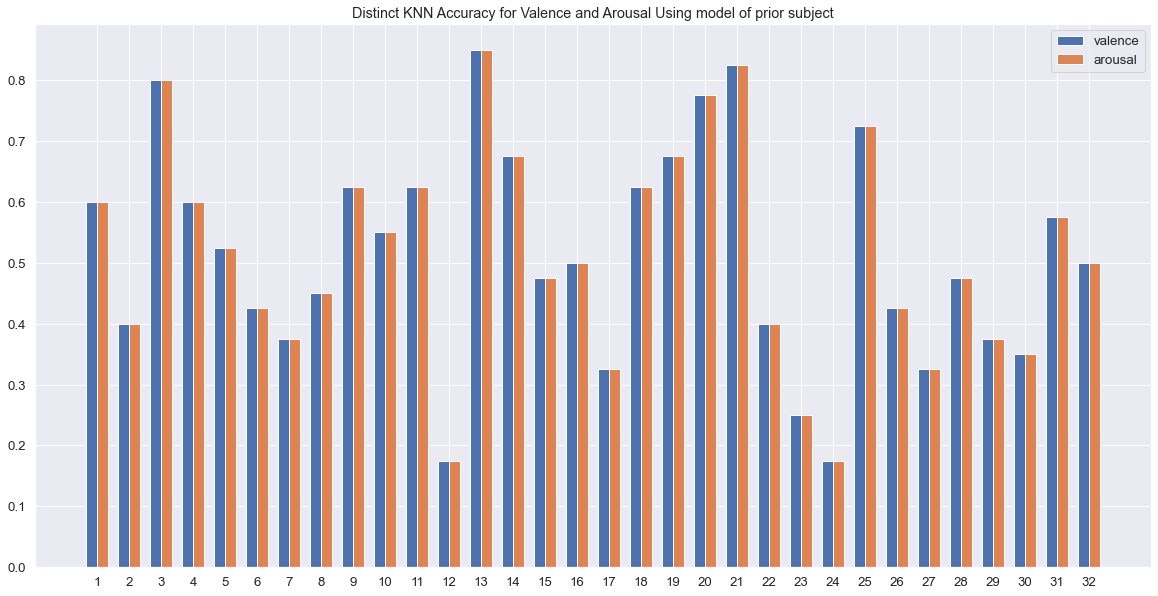

In [53]:
fig, ax = plt.subplots(figsize=(20,10))
index = np.arange(1, len(indi_val_knn)+1) 

indi_arr_knn = np.array([indi_val_knn[_] for _ in indi_val_knn ])
indi_arr_ar_knn = np.array([indi_aro_knn[_] for _ in indi_aro_knn ]) 
ax.bar(index - 0.35/2 , indi_arr_knn, 0.35, label = "valence")
ax.bar(index + 0.35/2, indi_arr_ar_knn,0.35, label = "arousal")
ax.set_xticks(index);
ax.set_title("Distinct KNN Accuracy for Valence and Arousal Using model of prior subject")
ax.legend()

> It seems that when the data samples of 32 participants with 40 videos are not sufficient for data dependent analysis
> 


# Proposed LSTM model Diagram

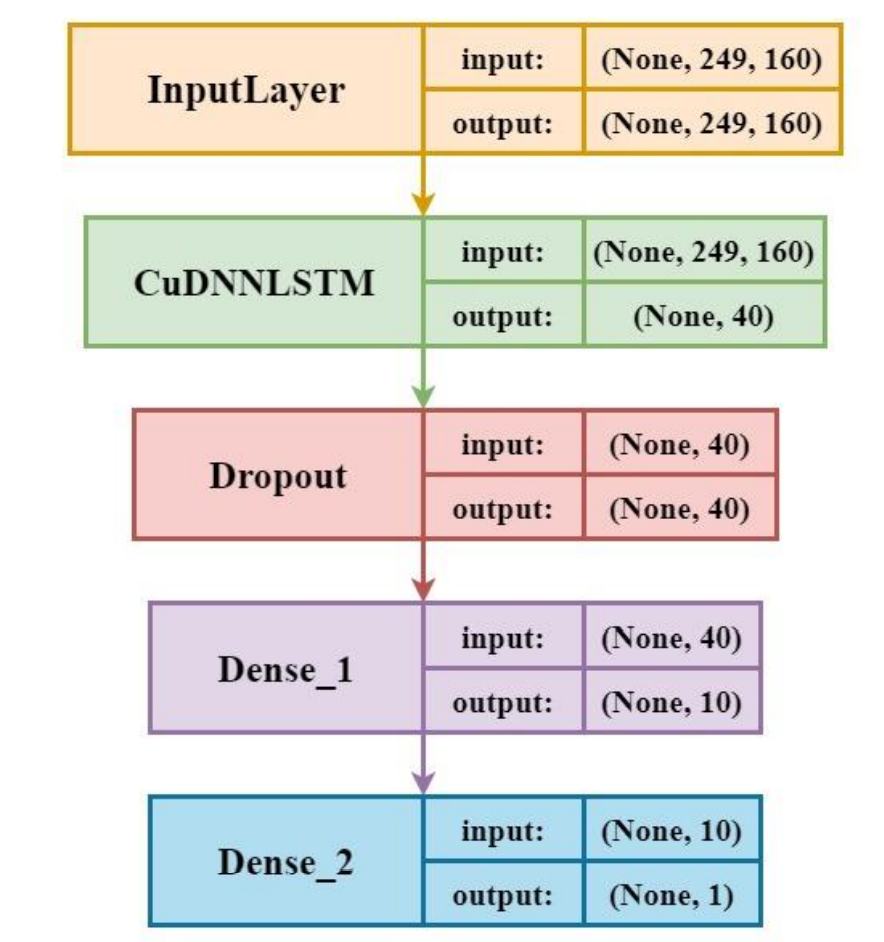

- Number of LSTM Nodes: 32, 40 
- Number of Dense 1 Nodes: 10, 20, 24, 32, 40 
- Activation for Dense 1: ’relu’, ’sigmoid’, ’tanh’
- Learning Rate: 1, 1e-1, 1e-2, 1e-3, 1e-4 
- Learning Rate Decay: 1e-5, 1e-6 

In [54]:
import math
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Dropout, MaxPooling3D, ConvLSTM2D
from keras.layers import LSTM,BatchNormalization,Activation, InputLayer, CuDNNLSTM
import datetime
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import RMSprop,Adam

In [55]:
# create and fit the LSTM network 
model = Sequential()
 

model.add(LSTM(64, input_shape = (indi_psd["subject_1"].shape[1], 1),return_sequences=True))  
model.add(Activation('relu')) 

model.add(LSTM(32)) 
model.add(Activation('relu')) 

model.add(Dropout(0.25)) 
 
model.add(Dense(10))
model.add(Activation('relu')) 

model.add(Dense(1))
model.add(Activation('sigmoid'))

adam = Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer="adam") 
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 64)           16896     
                                                                 
 activation (Activation)     (None, 128, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 activation_2 (Activation)   (None, 10)                0

In [56]:
history = model.fit(indi_psd["subject_1"].reshape(40,-1,1) , indi_valence["subject_1"].reshape(-1,1),  epochs=100, batch_size=20, verbose=2, validation_split=0.3)

Epoch 1/100
2/2 - 4s - loss: 0.6957 - val_loss: 0.7073 - 4s/epoch - 2s/step
Epoch 2/100
2/2 - 0s - loss: 0.6903 - val_loss: 0.7165 - 173ms/epoch - 86ms/step
Epoch 3/100
2/2 - 0s - loss: 0.6897 - val_loss: 0.7228 - 175ms/epoch - 88ms/step
Epoch 4/100
2/2 - 0s - loss: 0.6850 - val_loss: 0.7282 - 166ms/epoch - 83ms/step
Epoch 5/100
2/2 - 0s - loss: 0.6832 - val_loss: 0.7334 - 179ms/epoch - 89ms/step
Epoch 6/100
2/2 - 0s - loss: 0.6800 - val_loss: 0.7399 - 174ms/epoch - 87ms/step
Epoch 7/100
2/2 - 0s - loss: 0.6747 - val_loss: 0.7509 - 170ms/epoch - 85ms/step
Epoch 8/100
2/2 - 0s - loss: 0.6758 - val_loss: 0.7622 - 171ms/epoch - 85ms/step
Epoch 9/100
2/2 - 0s - loss: 0.6669 - val_loss: 0.7751 - 174ms/epoch - 87ms/step
Epoch 10/100
2/2 - 0s - loss: 0.6808 - val_loss: 0.7840 - 191ms/epoch - 96ms/step
Epoch 11/100
2/2 - 0s - loss: 0.6558 - val_loss: 0.7905 - 175ms/epoch - 88ms/step
Epoch 12/100
2/2 - 0s - loss: 0.6684 - val_loss: 0.7972 - 159ms/epoch - 80ms/step
Epoch 13/100
2/2 - 0s - loss: 

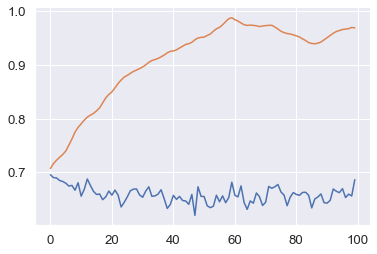

In [57]:
import seaborn as sns
sns.set(font_scale=1.2)
plt.plot(history.history["loss"], label = )
plt.plot(history.history["val_loss"])
sns.despine()

In [58]:
yhat = model.predict(indi_psd["subject_2"].reshape(40,-1,1))

In [59]:
pred = np.where(yhat > 0.5 , 1, 0)

In [62]:
acc = accuracy_score(indi_valence["subject_2"], pred)  
print("Paper Proposed model accuracy with seperate subjects for train and test: ", np.round(acc*100))

Paper Proposed model accuracy with seperate subjects for train and test:  55.0
